# Project - GAN & VAE, applied on CelebA dataset

### by: Jerome Dauba


In [ ]:
!nvidia-smi

Mon Apr 12 03:11:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    35W / 250W |   1997MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
import os
import zipfile
from natsort import natsorted
from PIL import Image
from tqdm.notebook import trange, tqdm
import matplotlib.animation as animation
from IPython.display import HTML
from google.colab import output
from google.colab import files
import time
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
import imageio
from PIL import Image
import sys
import shutil
import cv2
import random
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Data Loading
We provide the code for data loading.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip the downloaded file
download_path = '/content/drive/MyDrive/MDI 341/GAN/img_align_celeba.zip'
dataset_folder = '/content/CelebA'
# with zipfile.ZipFile(download_path, 'r') as ziphandler:
#   ziphandler.extractall(dataset_folder)

## Create a custom Dataset class
class CelebADataset():
  def __init__(self, root_dir, transform):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img

## Load the dataset 
# Path to directory with all the images
img_folder = f'{dataset_folder}/img_align_celeba'
# Spatial size of training images, images are resized to this size.
image_size = 64
# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])
# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(img_folder, transform)

## Create a dataloader 
# Batch size during training
batch_size = 32
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                num_workers=2,
                                                pin_memory=pin_memory,
                                                shuffle=True)

Let's visualize some celeb faces from the dataset :

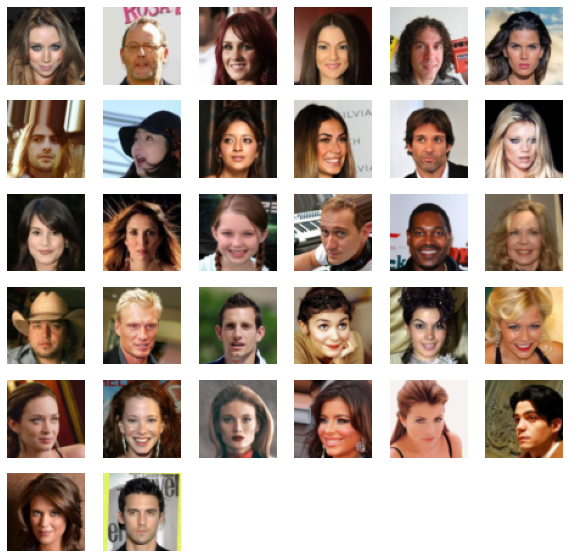

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(celeba_dataloader))
plt.figure(figsize=(10,10))
plt.title("Training images")
for i in range(batch_size):
  plt.subplot(6,6,i+1)
  plt.axis("off")
  plt.imshow(np.transpose(vutils.make_grid(real_batch[i].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## Class Architecture

In [ ]:
# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 128

# Number of channels in the image :
nc = 3

# Image size :
image_size = 64

# Weight init :
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
      try:
          nn.init.kaiming_normal_(m.weight.data, mode='fan_in', nonlinearity='leaky_relu')
          nn.init.normal_(m.biais.data, 0.0, 0.01)
          print("Init of Convolution OK")
      except:
        print("One error found in weight init")
        pass
    elif classname.find('BatchNorm') != -1:
        try:
          # nn.init.kaiming_normal_(m.weight.data, a=0.2, mode='fan_out', nonlinearity='leaky_relu')
          nn.init.normal_(m.weight.data, 0.0, 0.02)
          print("Init of Batchnorm OK")
          nn.init.normal_(m.biais.data, 0.0, 0.01)
        except:
          print("One error found in weight init")
          pass

GAN ARCHITECTURE :

In [ ]:
#Travailler sur l'initialisation des poids !
class Generator(nn.Module):
  #Mettre des BatchNorm !
    def __init__(self, g_input_dim):
        super(Generator, self).__init__()
        self.convTr1 = nn.ConvTranspose2d(g_input_dim, ngf * 8, 4, 1, 0, bias=False) #
        self.bn1 = nn.BatchNorm2d(ngf * 8)
        self.convTr2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False) #
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.convTr3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False) #
        self.bn3 = nn.BatchNorm2d(ngf * 2)
        self.convTr4 = nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False) #
        self.bn4 = nn.BatchNorm2d(ngf)
        self.convTr5 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False) #
 
    # forward method
    def forward(self, x):
        # print("\n \n")
        # print("Generator :", "\n")
        # print("Initial shape",x.shape)
        x = x.view(batch_size,z_dim, 1,1)
        # print("After reshaping:",x.shape)
        x = self.convTr1(x)
        x = self.bn1(x)
        x = F.relu(x)
        # print("After 1st Conv Transpose:",x.shape)
        x = self.convTr2(x)
        x = self.bn2(x)
        x = F.relu(x)
        # print("After 2nd Conv Transpose:",x.shape)
        x = self.convTr3(x)
        x = self.bn3(x)
        x = F.relu(x)
        # print("After 3rd Conv Transpose:",x.shape)
        x = self.convTr4(x)
        x = self.bn4(x)
        x = F.relu(x)
        # print("After 4th Conv Transpose:",x.shape)
        x = self.convTr5(x)
        # print("After 5th Conv Transpose:",x.shape)
        return torch.tanh(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(nc,ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf,ndf*2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf*2)
        self.conv3 = nn.Conv2d(ndf*2,ndf*4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf*4)
        self.conv4 = nn.Conv2d(ndf*4,ndf*8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf*8)
        self.conv5 = nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False)
        
    
    # forward method
    def forward(self, x):
        # print("\n \n")
        # print("Discriminator :", "\n")
        # print("Entry shape",x.shape)
        x = x.view(batch_size,nc,image_size,image_size)
        # print("Initial shape after view",x.shape)
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)
        # print("After 1st Conv:",x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.2)
        # print("After 2nd Conv:",x.shape)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, 0.2)
        # print("After 3rd Conv:",x.shape)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.leaky_relu(x, 0.2)
        # print("After 4th Conv:",x.shape)
        x = self.conv5(x)
        # print("After 5th Conv:",x.shape)
        x = x.view(batch_size,-1)
        x = torch.sigmoid(x)
        # print(x.shape)
        return(x)

ENCODER ARCHITECTURE : the goal of the encoder is to enable us to retrieve the latent representation of any image in input.

The encoder will be train over the GAN.

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(nc,ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf,ndf*2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf*2)
        self.drop = nn.Dropout(p=0.2)
        self.conv3 = nn.Conv2d(ndf*2,ndf*4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf*4)
        self.conv4 = nn.Conv2d(ndf*4,ndf*8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf*8)
        self.conv5 = nn.Conv2d(ndf*8, z_dim, 4, 1, 0, bias=False)
        # self.linear = nn.Linear(z_dim, z_dim, bias=True)
        

    # forward method
    def forward(self, x):
        # print("\n \n")
        # print("Encoder :", "\n")
        # print("Entry shape",x.shape)
        x = x.view(batch_size,nc,image_size,image_size)
        # print("Initial shape after view",x.shape)
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.drop(x)
        # print("After 1st Conv:",x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.drop(x)
        # print("After 2nd Conv:",x.shape)
        x = self.conv3(x)
        # x = self.bn3(x)
        x = F.leaky_relu(x, 0.2)
        # print("After 3rd Conv:",x.shape)
        x = self.conv4(x)
        # x = self.bn4(x)
        x = F.leaky_relu(x, 0.2)
        x = self.drop(x)
        # print("After 4th Conv:",x.shape)
        x = self.conv5(x) #Taille attendue : batch_size * z_dim
        # x = F.leaky_relu(x, 0.2)
        x = x.view(batch_size,z_dim)
        # print("After 5th Conv:",x.shape)
        
        # print(x.shape)
        return(x)

## We instantiate the networks

In [ ]:
# build network
z_dim = 100

G = Generator(g_input_dim = z_dim).to(device)
D = Discriminator().to(device)
E = Encoder().to(device)

You can check if the architectures are correct.

In [ ]:
G.apply(weights_init)

One error found in weight init
Init of Batchnorm OK
One error found in weight init
One error found in weight init
Init of Batchnorm OK
One error found in weight init
One error found in weight init
Init of Batchnorm OK
One error found in weight init
One error found in weight init
Init of Batchnorm OK
One error found in weight init
One error found in weight init


Generator(
  (convTr1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convTr2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convTr3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convTr4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convTr5): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

In [ ]:
D.apply(weights_init)

One error found in weight init
One error found in weight init
Init of Batchnorm OK
One error found in weight init
One error found in weight init
Init of Batchnorm OK
One error found in weight init
One error found in weight init
Init of Batchnorm OK
One error found in weight init
One error found in weight init


Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

In [ ]:
E.apply(weights_init)

One error found in weight init
One error found in weight init
Init of Batchnorm OK
One error found in weight init
One error found in weight init
Init of Batchnorm OK
One error found in weight init
One error found in weight init
Init of Batchnorm OK
One error found in weight init
One error found in weight init


Encoder(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 100, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

## Training configuration
Chose the discriminator loss.

In [ ]:
# loss
criterion = nn.BCELoss()
criterion_encoder = nn.MSELoss()

# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr = lr, betas=(0.5, 0.999))
E_optimizer = optim.Adam(E.parameters(), lr = 0.0002, betas=(0.5, 0.999))

Now, let's code the discriminator update

In [ ]:
def add_noise(x, std):
  noisy = torch.normal(mean=x.type(torch.float64), std=std)
  return(noisy.float())

test = torch.tensor(np.random.randint(10,size=(10,10)))
# add_noise(test, std=0.2)

In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x, torch.ones(batch_size, 1)
    
    ## TEST ##
    # Adding noise to real images to prevent from overfitting
    # x_real = add_noise(x_real, std=0.1)

    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    

    D_output = D(x_real)
    # print("Discriminator OK")


    D_real_loss = criterion(D_output, y_real) # J'entraine le discriminator à bien reconnaitre les vraies images
    

    # train discriminator on fake
    z = Variable(torch.randn(batch_size, z_dim).to(device))

    x_fake, y_fake = G(z), Variable(torch.zeros(batch_size, 1).to(device))
    # print("Generator OK")

    # print("G(z) shape:",x_fake.shape)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake) # J'entraine le discriminator à bien reconnaitre les fausses images
    

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

Now, let's code the generator update

In [ ]:
def G_train():
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(batch_size, z_dim).to(device))
    y = Variable(torch.ones(batch_size, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
def E_train():
    #=======================Train the Encoder=======================#
    E.zero_grad()

    y_true = Variable(torch.randn(batch_size, z_dim).to(device))

    with torch.no_grad():
      x_generator = G(y_true)

    y_hat = E(x_generator)
    E_loss = criterion_encoder(y_hat, y_true)

    # gradient backprop & optimize ONLY E's parameters
    E_loss.backward()
    E_optimizer.step()
        
    return E_loss.data.item()

We provide this visualization function.

In [ ]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)

# # Create a wall of generated MNIST images
def plot_generated_images(images, clear):
  plt.figure(figsize=(15,15))
  for i,image in enumerate(images[:batch_size]):
    plt.subplot(6,6,i+1)
    plt.axis("off")
    plt.imshow(image[0])
    if clear:
      output.clear()
  plt.show()

Function for saving model weights :

In [ ]:
def load_weights(path_D, path_G, path_E, encoder):
    if encoder :
      D.load_state_dict(torch.load(path_D))
      D.eval()
      G.load_state_dict(torch.load(path_G))
      G.eval()
      E.load_state_dict(torch.load(path_E))
      E.eval()
    else:
      D.load_state_dict(torch.load(path_D))
      D.eval()
      G.load_state_dict(torch.load(path_G))
      G.eval()


def save_models(download, encoder_only):
  Path_D = "state_dict_model_D.pt"
  Path_G = "state_dict_model_G.pt"
  Path_E = "state_dict_model_E.pt"
  if encoder_only :
    torch.save(E.state_dict(), Path_E)
    if download:
      files.download(Path_E) 
  else :
    torch.save(D.state_dict(), Path_D)
    torch.save(G.state_dict(), Path_G)
    torch.save(E.state_dict(), Path_E)
    if download :
      files.download(Path_D) 
      files.download(Path_G)
      files.download(Path_E)

Autres réparations :

In [ ]:
image_de_remplacement1 = plt.imread('/content/CelebA/img_align_celeba/002499.jpg')
plt.imsave('/content/CelebA/img_align_celeba/002399.jpg',image_de_remplacement1)

image_de_remplacement2 = plt.imread('/content/CelebA/img_align_celeba/015860.jpg')
plt.imsave('/content/CelebA/img_align_celeba/015760.jpg',image_de_remplacement2)

'/content/CelebA/img_align_celeba/001649.jpg'

image_de_remplacement3 = plt.imread('/content/CelebA/img_align_celeba/001749.jpg')
plt.imsave('/content/CelebA/img_align_celeba/001649.jpg',image_de_remplacement3)

'/content/CelebA/img_align_celeba/027879.jpg'

image_de_remplacement3 = plt.imread('/content/CelebA/img_align_celeba/026879.jpg')
plt.imsave('/content/CelebA/img_align_celeba/027879.jpg',image_de_remplacement3)

In [ ]:
# if os.path.exists('/content/CelebA/img_align_celeba/002399.jpg'):
#     # removing the file using the os.remove() method
#     os.remove('/content/CelebA/img_align_celeba/002399.jpg')

## Train Loop GAN

The GAN is already train, we now train the Encoder to retrieve the latent representation of a photo

In [ ]:
load_weights(path_D="state_dict_model_D.pt", path_G="state_dict_model_G.pt",path_E="state_dict_model_E.pt", encoder=True)

In [ ]:
# n_epoch = 3
# liste_animation = []
# for epoch in range(1, n_epoch+1):           
#     D_losses, G_losses = [], []
#     for batch_idx, x in enumerate(celeba_dataloader):
#         try:
#             loss_discriminator = torch.mean(torch.FloatTensor(D_losses))

#             D_losses.append(D_train(x))

#             G_losses.append(G_train())
#         except:
#           print("One error found")

#     print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
#             (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    
#     with torch.no_grad():
#         brightness_correction = 0.6
#         test_z = Variable(torch.randn(batch_size, z_dim).to(device))
#         generated = G(test_z)
#         fig = plt.figure(figsize=(4,4))
#         ims = [[plt.imshow(np.transpose(i.cpu(),(1,2,0)), animated=True)] for i in generated]
#         ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
#         liste_animation.append(ani)
#         images = [[np.transpose(i.cpu(),(1,2,0))+brightness_correction] for i in generated]
#         output.clear()
#         plot_generated_images(images)

#     # Saving model weights
#     print(epoch)
#     if epoch == n_epoch:
#       save_models(download=True)

## Training the Encoder :

In [ ]:
load_weights(path_D="state_dict_model_D.pt", path_G="state_dict_model_G.pt",path_E="state_dict_model_E.pt", encoder=False)

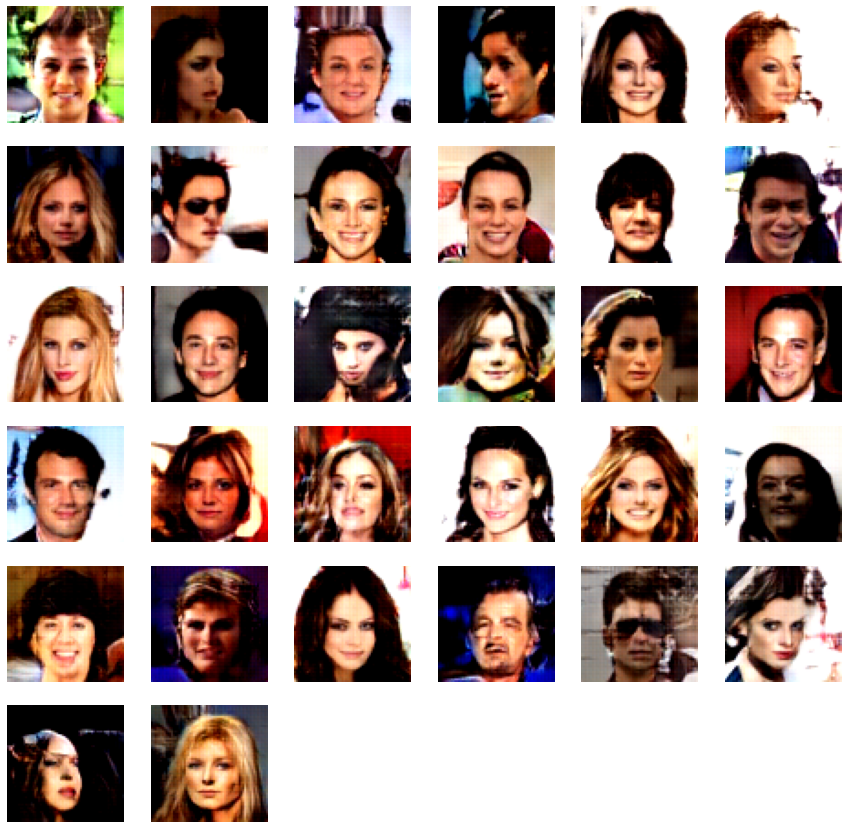

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

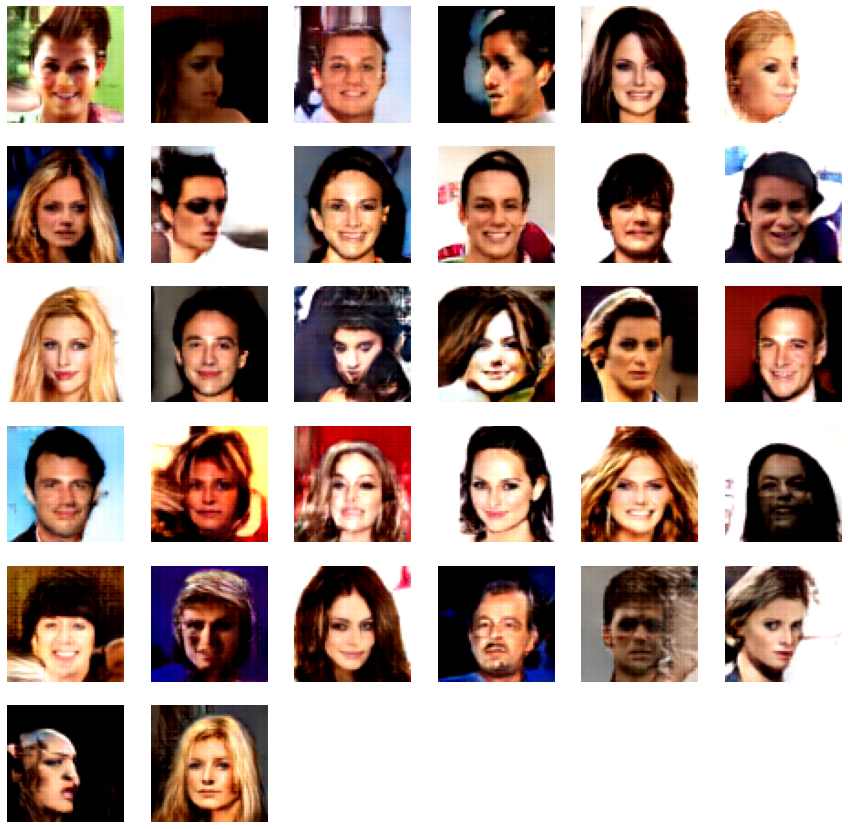

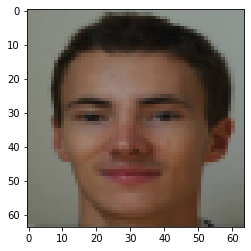

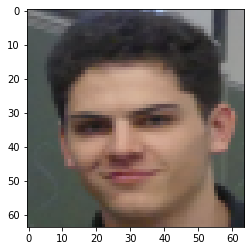

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

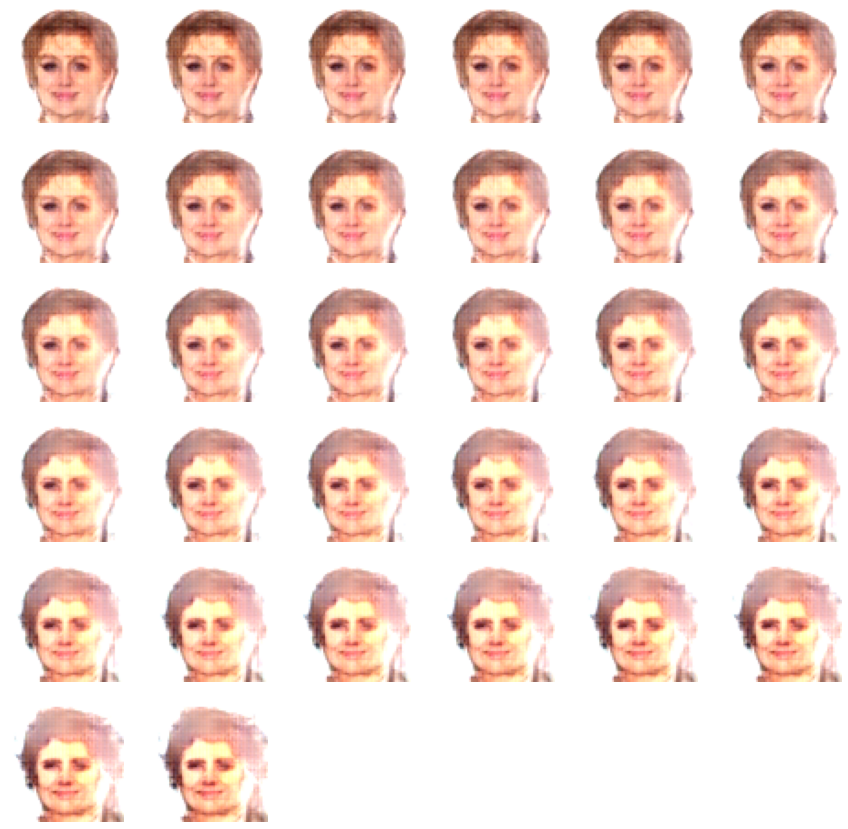

4


In [ ]:
n_epoch = 15
for epoch in range(1, n_epoch+1):           
    E_losses = []
    for batch_idx, x in enumerate(celeba_dataloader):
        try:
            E_losses.append(E_train())

        except:
          print("One error found")

    print("Epoch:",n_epoch, " Loss Encoder:",torch.mean(torch.FloatTensor(E_losses)))
    
    with torch.no_grad():
      brightness_correction = 0.6
      test_z = Variable(torch.randn(batch_size, z_dim).to(device))
      generated = G(test_z)
      latent_rpz_encoder = E(generated)
      reconstructed_image = G(latent_rpz_encoder)


      images_true = [[np.transpose(i.cpu(),(1,2,0))+brightness_correction] for i in generated]
      images_reconstructed = [[np.transpose(i.cpu(),(1,2,0))+brightness_correction] for i in reconstructed_image]
      output.clear()
      plot_generated_images(images_true, clear=True)
      plot_generated_images(images_reconstructed, clear=False)

      print("")

      test_custom_data(mode='duo', interpolation='slerp',image1='huot1.png', image2='swan1.png')

    # Saving model weights
    print(epoch)
    if epoch == n_epoch:
      save_models(download=True, encoder_only=True)

In [ ]:
save_models(download=True, encoder_only=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# TEST

## TEST Functions

In [ ]:
# load_weights(path_D="state_dict_model_D.pt", path_G="state_dict_model_G.pt",path_E="state_dict_model_E.pt", encoder=True)

In [ ]:
def create_rand_tensor(interpolation,custom_images,first, last):
  random_tensor = torch.zeros(batch_size, z_dim)

  if interpolation == 'linear':
    random_tensor1 = torch.randn(1, z_dim)
    random_tensor2 = torch.randn(1, z_dim)
    if custom_images == 'duo':
      random_tensor1 = first
      random_tensor2 = last
    elif custom_images == 'solo':
      random_tensor1 = first

    random_tensor[0,:] = random_tensor1
    random_tensor[-1,:] = random_tensor2
    for i in range(1,random_tensor.shape[0]):
      lambda_ = i / batch_size
      if custom_images == 'solo':
        random_tensor2 = 0.7*random_tensor1 + (torch.randn(z_dim).to(device)*0.3)
      random_tensor[i] = lambda_*random_tensor2 + (1-lambda_)*random_tensor1

  elif interpolation == 'slerp' :
    # We will perform rotations around a latent space vector :
    if custom_images == 'duo':
      random_tensor1 = first
      random_tensor[0,:] = random_tensor1
      random_tensor2 = last
      random_tensor[-1,:] = random_tensor2
    elif custom_images == 'solo':
      random_tensor1 = first
      random_tensor[0,:] = random_tensor1
    else :
      random_tensor1 = torch.randn(z_dim)
      random_tensor2 = torch.randn(z_dim)
    
    def slerp(val, low, high):
      low = low.cpu()
      high = high.cpu()
      omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
      so = np.sin(omega)
      out = np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high
      return out.to(device)

    liste_ind = np.linspace(0,1,batch_size)
    for i, ind in enumerate(liste_ind):
      if custom_images == 'solo':
        random_tensor2 = random_tensor1 + (torch.randn(z_dim).to(device)*0.3)
      random_tensor[i,:] = slerp(ind, random_tensor1, random_tensor2)

  else:
    random_tensor = torch.randn(batch_size, z_dim)

  return(random_tensor)



def create_gif(create, raw_images):
  if create:
    path = './temp'
    shutil.rmtree(path)
    os.mkdir(path)
    # Saving in a temp folder all the images :
    liste_image = []
    for i,liste in enumerate(raw_images):
        data = liste[0]
        data = np.array(data)
        #Rescaling image
        rescaled_data = (data - np.min(data))/(np.max(data) - np.min(data))
        rescaled_data *= 255
        rescaled_data = rescaled_data.astype(np.uint8)
        #Resizing image
        image_resized = cv2.resize(rescaled_data, dsize=(image_size*3, image_size*3), interpolation=cv2.INTER_AREA)
        im = Image.fromarray(image_resized, 'RGB')
        liste_image.append(im)
        im.save(f"temp/{100+i}.png")

    filenames = [fn for fn in os.listdir('/content/temp') if fn.endswith('.png')]
    filenames = sorted(filenames, key=lambda x: float(x[:-4]))
    images = []
    for image in filenames:
        images.append(imageio.imread(path+'/'+image))
    imageio.mimsave('Interp.gif', images, fps=3)

def rescale(x):
  rescaled = (x-x.min())/(x.max()- x.min())
  return(rescaled)

def import_image(image_path):
  image = plt.imread(image_path)
  image = image[:,:,:3] #Only RGB data 
  image_resized = cv2.resize(image, dsize=(image_size, image_size), interpolation=cv2.INTER_AREA)
  plt.figure(figsize=(4,4))
  plt.imshow(image_resized)
  plt.show()
  image_resized = np.transpose(image_resized,(2,0,1))
  # image_resized = rescale(image_resized)
  return(Variable(torch.tensor(image_resized, dtype=torch.float64).to(device)))


def find_latent_rpz(image_path, debug, image_batch):

  image = import_image(image_path)
  # image = torch.tensor(face4_raw).to(device)
  image = image.reshape(3,image_size,image_size)
  image = image
  
  tensor_images = torch.zeros(batch_size,3,image_size,image_size).to(device)
  if not debug:
    for i in range(batch_size):
      tensor_images[i,:,:,:] = image.to(device)
  else :
    tensor_images = image_batch
    tensor_images[0,:,:,:] = image.to(device)
  
  #On fait passer le tenseur d'images dans l'Encodeur :
  with torch.no_grad():
    latent_rpz_batch = E(tensor_images)
  latent_rpz = latent_rpz_batch[0,:]

  return(latent_rpz)

## Test validation entrainement Encoder :

In [ ]:
load_weights(path_D="state_dict_model_D.pt", path_G="state_dict_model_G.pt",path_E="state_dict_model_E.pt", encoder=False)

In [ ]:
def test_custom_data(mode, interpolation,image1, image2):
  with torch.no_grad():
    brightness_correction = 0.6
    first_latent_image = find_latent_rpz(image1, debug=False, image_batch=False)

    last_latent_image = find_latent_rpz(image2, debug=False, image_batch=False)

    custom_latent_batch_interp = create_rand_tensor(interpolation=interpolation, custom_images=mode, first=first_latent_image, last=last_latent_image).to(device)
    generated_test = G(custom_latent_batch_interp)

    images_true_test = [[np.transpose(i.cpu(),(1,2,0))+brightness_correction] for i in generated_test]
    create_gif(create=False, raw_images=images_true_test)
    plot_generated_images(images_true_test, clear=False)

## Generate new faces with GAN :

In [ ]:
with torch.no_grad():
    brightness_correction = 0.6
    random_tensor = create_rand_tensor(interpolation='slerp', first=False, last=False)
    test_z = Variable((random_tensor).to(device))
    generated = G(test_z) + brightness_correction

    images = [[np.transpose(i.cpu(),(1,2,0))] for i in generated]
    create_gif(create=True, raw_images=images)
    output.clear()
    plot_generated_images(images)

## Generate custom faces with GAN & Encoder :

In [ ]:
with torch.no_grad():
      brightness_correction = 0.6
      test_z = Variable(torch.randn(batch_size, z_dim).to(device))
      generated = G(test_z) + brightness_correction #32*3*64*64
      latent_rpz_encoder = E(generated) #32*100

      reconstructed_image = G(latent_rpz_encoder) #32*3*64*64

      images_true = [[np.transpose(i.cpu(),(1,2,0))+brightness_correction] for i in generated]
      images_reconstructed = [[np.transpose(i.cpu(),(1,2,0))+brightness_correction] for i in reconstructed_image]
      output.clear()
      # plot_generated_images(images_true, clear=False)
      plot_generated_images(images_reconstructed, clear=False)

tensor(-0.0122, device='cuda:0')
tensor(0.4997, device='cuda:0')
